In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
train_set = torchvision.datasets.MNIST(root='dataset/',train=True,transform=transforms.ToTensor(),download=True)
test_set = torchvision.datasets.MNIST(root='dataset/',train=False,transform=transforms.ToTensor(),download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=50)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=50)

torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 14])
torch.Size([50, 1, 28, 14])
labels: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3])


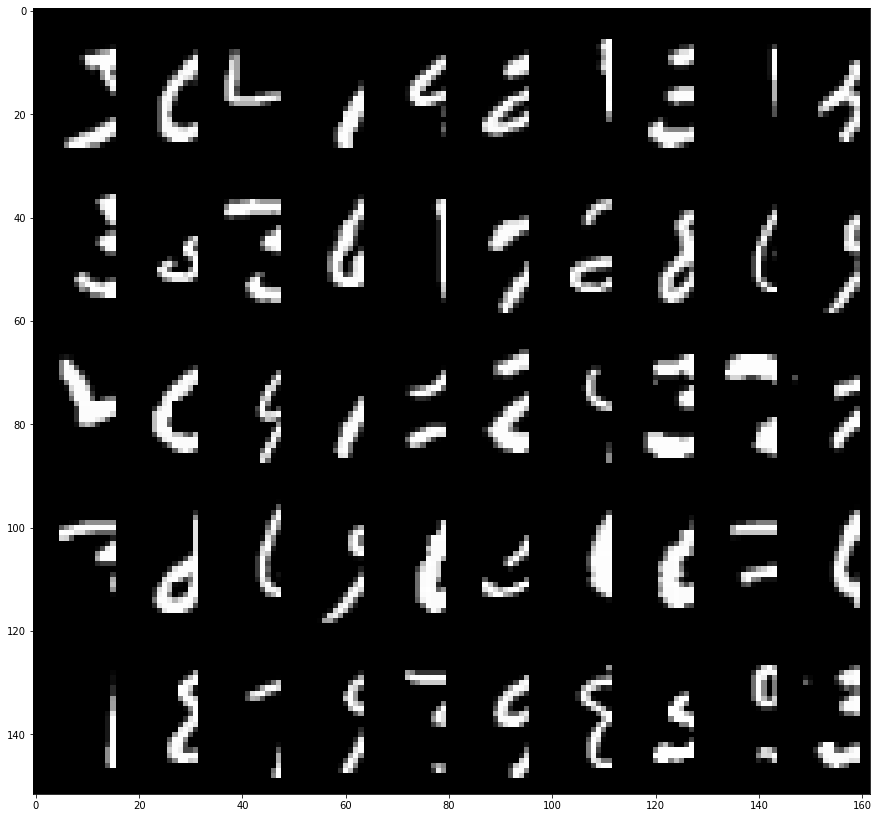

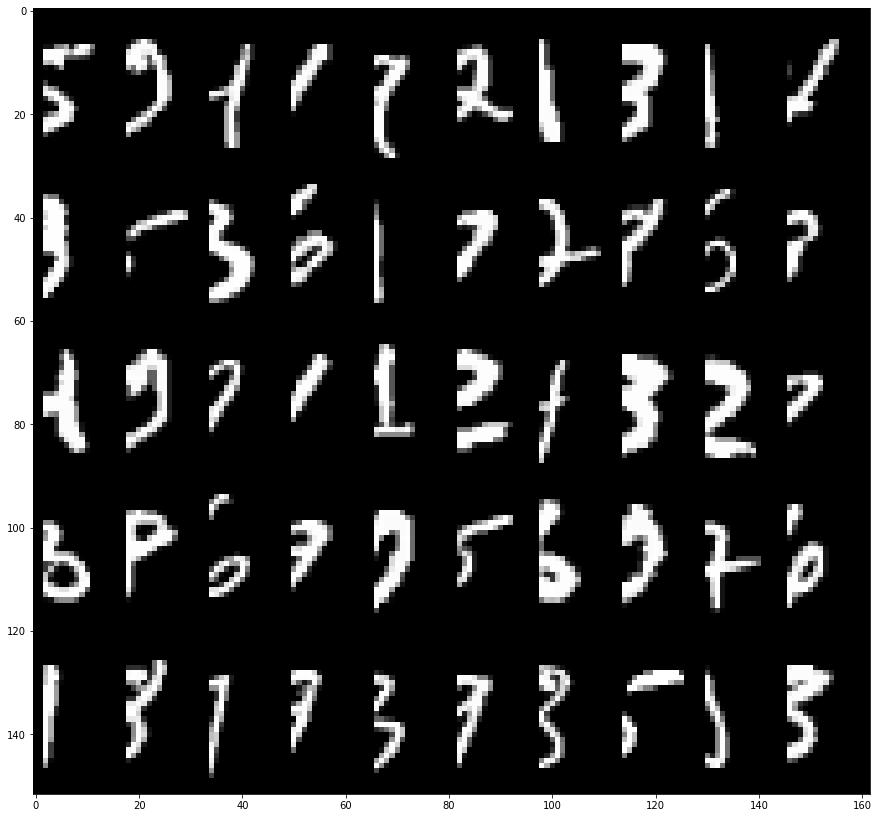

In [ ]:
# experimenting how to divide the images
batch = next(iter(train_loader))
images, labels = batch
print(images.shape)
images_l = images[:,:,:,:14]
print(images_l.shape)

images_r = images[:,:,:,14:]
print(images_r.shape)

grid_l = torchvision.utils.make_grid(images_l, nrow=10)
grid_r = torchvision.utils.make_grid(images_r, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid_l,(1,2,0)))
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid_r,(1,2,0)))

print('labels:',labels)

In [ ]:
def corrLoss(x,y):
  vx = x - torch.mean(x)
  vy = y - torch.mean(y)
  cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
  return cost

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        
        # X part of the model
        self.hx_conv1 = nn.Conv2d(in_channels=1,out_channels=128,kernel_size=3) #  1*28*14 --> 128*28*14
        self.pool = nn.MaxPool2d(2,stride=2) # 128*28*14 --> 128*13*6
        self.batch_norm_x_1 = nn.BatchNorm2d(128) #  
        self.hx_conv2 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3) # 128*13*6 --> 64*13*6
        #self.pool = nn.MaxPool2d(2,stride=2) # 64*13*6 --> 64*5*2
        self.batch_norm_x_2 = nn.BatchNorm2d(64)
        # two layers of convolution now using 2 dense layers
        self.hx_fc1 = nn.Linear(in_features=64*5*2,out_features=500 ) # 64*5*2 -->500
        self.hx_fc2 = nn.Linear(in_features=500,out_features=300) # 500 --> 300

        # Y part of the model
        self.hy_conv1 = nn.Conv2d(in_channels=1,out_channels=128,kernel_size=3) #  1*28*14 --> 128*28*14
        #self.pool = nn.MaxPool2d(2,stride=2) # 128*28*14 --> 128*13*6 # --> already defined just use it in forward
        self.batch_norm_y_1 = nn.BatchNorm2d(128)
        self.hy_conv2 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3) # 128*13*6 --> 64*13*6
        #self.pool = nn.MaxPool2d(2,stride=2) # 64*13*6 --> 64*5*2 --> already defined just use it in forward
        self.batch_norm_y_2 = nn.BatchNorm2d(64)
        # apply reshape in forward
        # two layers of convolution now using 2 dense layers
        self.hy_fc1 = nn.Linear(in_features=64*5*2,out_features=500 ) # 64*5*2 -->500
        self.hy_fc2 = nn.Linear(in_features=500,out_features=300) # 500 --> 300

        # this is the common rep layer
        self.h = nn.Linear(in_features=300,out_features=50) #input to this layer is sum of output of hx_fc2 * hy_fc2

        # reconstructing x
        self.recx_fc1 = nn.Linear(in_features=50,out_features=294) # reshape 294 to 1*3*14*7 --> upsample this to 1*3*26*12 --> decon to 1*28*14
        #self.recx_fc2 = nn.Linear(in_features=200,out_features=28*14) # apply deconvolution layer later
        self.upsample_x= nn.Upsample(size=(26,12)) # 3*26*12
        self.deconv_x = nn.ConvTranspose2d(in_channels=3,out_channels=1,kernel_size=3) # 28*14


        # reconstructing y
        self.recy_fc1 = nn.Linear(in_features=50,out_features=294)
        #self.recy_fc2 = nn.Linear(in_features=200,out_features=28*14) # apply deconvolution layer later
        self.upsample_y= nn.Upsample(size=(26,12))
        self.deconv_y = nn.ConvTranspose2d(in_channels=3,out_channels=1,kernel_size=3)

        self.dropout = nn.Dropout(0.2)

    def forward(self,inpx,inpy):
        #print("0 :",inpx.shape)
        x = self.pool(F.relu(self.hx_conv1(inpx)))
        x = self.batch_norm_x_1(x)
        #print("1 :",x.shape)
        x = self.pool(F.relu(self.hx_conv2(x)))
        x = self.batch_norm_x_2(x)
        #print("2 :",x.shape)
        x = x.view(-1,64*5*2)
        #print("3 :",x.shape)
        hx1 = F.relu(self.hx_fc1(x))
        hx1 = self.dropout(hx1)
        hx2 = F.relu(self.hx_fc2(hx1))


        y = self.pool(F.relu(self.hy_conv1(inpy)))
        y = self.batch_norm_y_1(y)
        y = self.pool(F.relu(self.hy_conv2(y)))
        x = self.batch_norm_y_2(y)

        #print(y.shape)
        y = y.view(-1,64*5*2)
        hy1 = F.relu(self.hy_fc1(y))
        hy1 = self.dropout(hy1)
        hy2 = F.relu(self.hy_fc2(hy1))

        hidden_rep = hx2 + hy2 # 
        hidden_rep = F.relu(self.h(hidden_rep)) # input 300 output 50

        recx = F.relu(self.recx_fc1(hidden_rep)) # 50 to 294
        #recx = F.relu(self.recx_fc2(recx))
        recx = recx.reshape(-1,3,14,7)
        #print("1 recx size : ",recx.shape)
        recx = self.upsample_x(recx) # 3*26*12
        #print("2 recx size : ",recx.shape)
        recx = F.relu(self.deconv_x(recx)) # 1*28*14
        #print("3 recx size : ",recx.shape)

        recy = F.relu(self.recy_fc1(hidden_rep))
        recy = recy.reshape(-1,3,14,7)
        recy = self.upsample_y(recy)
        recy = F.relu(self.deconv_y(recy))
        #recy = F.relu(self.recy_fc2(recy))
        #recy = recy.reshape(-1,1,28,14)

        return hidden_rep,recx,recy,hx1,hx2,hy1,hy2

In [ ]:
network = Network()
network.to(device)

optimizer = optim.Adam(network.parameters(),lr=0.001)

In [ ]:
summary(network,[(1,28,14),(1,28,14)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 26, 12]           1,280
         MaxPool2d-2           [-1, 128, 13, 6]               0
       BatchNorm2d-3           [-1, 128, 13, 6]             256
            Conv2d-4            [-1, 64, 11, 4]          73,792
         MaxPool2d-5             [-1, 64, 5, 2]               0
       BatchNorm2d-6             [-1, 64, 5, 2]             128
            Linear-7                  [-1, 500]         320,500
           Dropout-8                  [-1, 500]               0
            Linear-9                  [-1, 300]         150,300
           Conv2d-10          [-1, 128, 26, 12]           1,280
        MaxPool2d-11           [-1, 128, 13, 6]               0
      BatchNorm2d-12           [-1, 128, 13, 6]             256
           Conv2d-13            [-1, 64, 11, 4]          73,792
        MaxPool2d-14             [-1, 6

In [ ]:
network_loss = []
network_accuracy = []
for epoch in range(50):
    total_loss = 0.0
    for batch in train_loader:
        images, labels = batch[0].to(device),batch[1].to(device)
        images_l = images[:,:,:,:14]
        images_r = images[:,:,:,14:]
        
        image_l_zero = torch.zeros(images_l.shape).to(device)
        image_r_zero = torch.zeros(images_r.shape).to(device)

        hidden_rep,recx,recy,hx1,hx2,hy1,hy2 = network(images_l,images_r)
        hidden_rep_l,recx_l,recy_l,hx1_l,hx2_l,hy1_l,hy2_l = network(images_l,image_r_zero)
        hidden_rep_r,recx_r,recy_r,hx1_r,hx2_r,hy1_r,hy2_r = network(image_l_zero,images_r)

        loss1 = F.mse_loss(recx,images_l) + F.mse_loss(recy,images_r) # reconstruction using both views ()
        loss2 = F.mse_loss(recx_l,images_l) + F.mse_loss(recy_l,images_r) # reconstruction using only left view
        loss3 = F.mse_loss(recx_r,images_l) + F.mse_loss(recy_r,images_r) # reconstruction using only right view

        loss4 = F.mse_loss(hx1,hy1) + F.mse_loss(hx2,hy2) # step computation want hidden layers --> started working after adding batch norm
        
        loss5 = F.mse_loss(recx_l,recx_r) + F.mse_loss(recy_l,recy_r) 

        loss6 = 0.02 * corrLoss(hidden_rep_l,hidden_rep_r) # regularization lamba = 0.02

        loss7 = 0.003 * corrLoss(hx1,hy1) + 0.05 * corrLoss(hx2,hy2) 
        
        loss = loss1 + loss2 + loss3 + loss4 + loss5 - loss6 - loss7

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    network_loss.append(total_loss)
    print("epoch: ",epoch,"loss: ",total_loss)

epoch:  0 loss:  388.67988657951355
epoch:  1 loss:  320.97832657396793
epoch:  2 loss:  249.77567137777805
epoch:  3 loss:  214.32473781704903
epoch:  4 loss:  194.99180600047112
epoch:  5 loss:  183.04968523979187
epoch:  6 loss:  174.59875433146954
epoch:  7 loss:  167.53580185770988
epoch:  8 loss:  162.84593475610018
epoch:  9 loss:  158.85256765037775
epoch:  10 loss:  155.7118693292141
epoch:  11 loss:  152.7915217280388
epoch:  12 loss:  150.64319699257612
epoch:  13 loss:  148.53602547198534
epoch:  14 loss:  146.84833370149136
epoch:  15 loss:  145.2983147352934
epoch:  16 loss:  144.02449352294207
epoch:  17 loss:  142.97941128909588
epoch:  18 loss:  141.76828571408987
epoch:  19 loss:  140.87597649544477
epoch:  20 loss:  139.91154166311026
epoch:  21 loss:  139.10153111070395
epoch:  22 loss:  138.25976080447435
epoch:  23 loss:  137.58514741808176
epoch:  24 loss:  136.89525777101517
epoch:  25 loss:  136.1526741310954
epoch:  26 loss:  135.60145150870085
epoch:  27 loss

In [ ]:
torch.save(network.state_dict(), "finalModel_100")

In [ ]:
# network = Network()
# network.load_state_dict(torch.load('finalModel_100'))
# network.eval()
# network.to(device)

In [ ]:
batch = next(iter(test_loader))
images, labels = batch[0].to(device),batch[1].to(device)

images_l = images[:,:,:,:14]
images_r = images[:,:,:,14:]

image_l_zero = torch.zeros(images_l.shape).to(device)
image_r_zero = torch.zeros(images_r.shape).to(device)

hidden_rep,recx,recy,hx1,hx2,hy1,hy2 = network(images_l,images_r)
hidden_rep_l,recx_l,recy_l,hx1_l,hx2_l,hy1_l,hy2_l = network(images_l,image_r_zero)
hidden_rep_r,recx_r,recy_r,hx1_r,hx2_r,hy1_r,hy2_r = network(image_l_zero,images_r)

<Figure size 432x288 with 0 Axes>

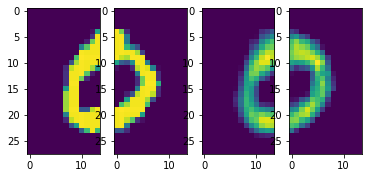

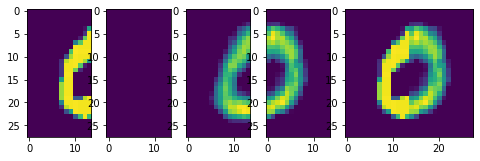

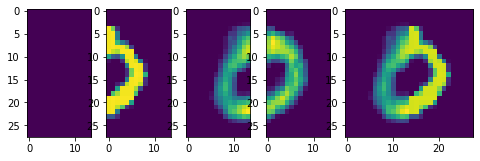

In [ ]:
plt.figure()
index = 3

plt.figure(figsize=(6,10))
plt.subplot(1,4,1)
plt.imshow(images_l[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,2)
plt.imshow(images_r[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,3)
plt.imshow(recx[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,4)
plt.imshow(recy[index].detach().cpu().reshape(28,14))


fig, axs = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig.set_size_inches(8, 12)
axs[0].imshow(images_l[index].detach().cpu().reshape(28,14))
axs[1].imshow(image_r_zero[index].detach().cpu().reshape(28,14))
axs[2].imshow(recx_l[index].detach().cpu().reshape(28,14))
axs[3].imshow(recy_l[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = images_l[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = recy_l[index].detach().cpu().reshape(28,14)
axs[4].imshow(comp_image)


fig1, axs1 = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig1.set_size_inches(8, 12)
axs1[0].imshow(image_l_zero[index].detach().cpu().reshape(28,14))
axs1[1].imshow(images_r[index].detach().cpu().reshape(28,14))
axs1[2].imshow(recx_r[index].detach().cpu().reshape(28,14))
axs1[3].imshow(recy_r[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = recx_r[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = images_r[index].detach().cpu().reshape(28,14)
axs1[4].imshow(comp_image)

<Figure size 432x288 with 0 Axes>

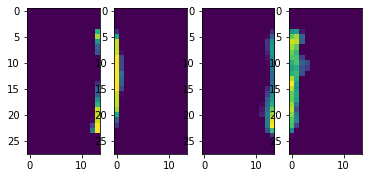

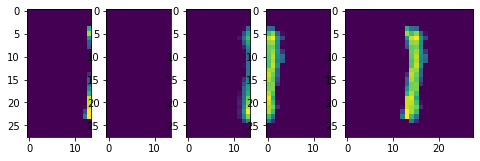

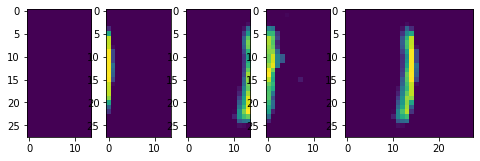

In [ ]:
plt.figure()
index = 40

plt.figure(figsize=(6,10))
plt.subplot(1,4,1)
plt.imshow(images_l[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,2)
plt.imshow(images_r[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,3)
plt.imshow(recx[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,4)
plt.imshow(recy[index].detach().cpu().reshape(28,14))


fig, axs = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig.set_size_inches(8, 12)
axs[0].imshow(images_l[index].detach().cpu().reshape(28,14))
axs[1].imshow(image_r_zero[index].detach().cpu().reshape(28,14))
axs[2].imshow(recx_l[index].detach().cpu().reshape(28,14))
axs[3].imshow(recy_l[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = images_l[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = recy_l[index].detach().cpu().reshape(28,14)
axs[4].imshow(comp_image)


fig1, axs1 = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig1.set_size_inches(8, 12)
axs1[0].imshow(image_l_zero[index].detach().cpu().reshape(28,14))
axs1[1].imshow(images_r[index].detach().cpu().reshape(28,14))
axs1[2].imshow(recx_r[index].detach().cpu().reshape(28,14))
axs1[3].imshow(recy_r[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = recx_r[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = images_r[index].detach().cpu().reshape(28,14)
axs1[4].imshow(comp_image)

<Figure size 432x288 with 0 Axes>

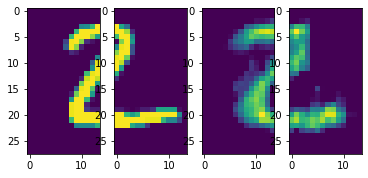

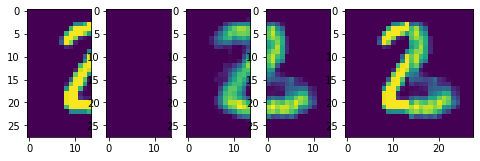

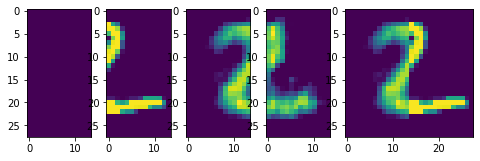

In [ ]:
plt.figure()
index = 1

plt.figure(figsize=(6,10))
plt.subplot(1,4,1)
plt.imshow(images_l[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,2)
plt.imshow(images_r[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,3)
plt.imshow(recx[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,4)
plt.imshow(recy[index].detach().cpu().reshape(28,14))


fig, axs = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig.set_size_inches(8, 12)
axs[0].imshow(images_l[index].detach().cpu().reshape(28,14))
axs[1].imshow(image_r_zero[index].detach().cpu().reshape(28,14))
axs[2].imshow(recx_l[index].detach().cpu().reshape(28,14))
axs[3].imshow(recy_l[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = images_l[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = recy_l[index].detach().cpu().reshape(28,14)
axs[4].imshow(comp_image)


fig1, axs1 = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig1.set_size_inches(8, 12)
axs1[0].imshow(image_l_zero[index].detach().cpu().reshape(28,14))
axs1[1].imshow(images_r[index].detach().cpu().reshape(28,14))
axs1[2].imshow(recx_r[index].detach().cpu().reshape(28,14))
axs1[3].imshow(recy_r[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = recx_r[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = images_r[index].detach().cpu().reshape(28,14)
axs1[4].imshow(comp_image)

<Figure size 432x288 with 0 Axes>

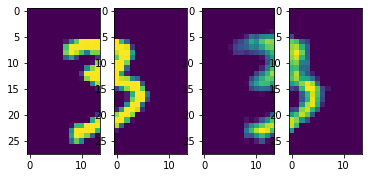

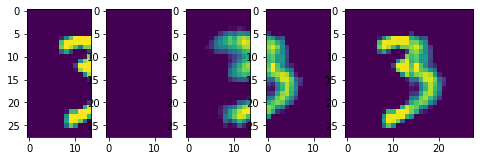

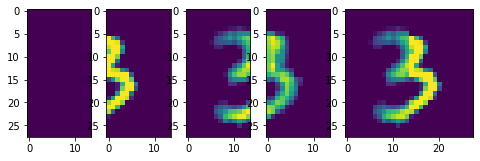

In [ ]:
plt.figure()
index = 30

plt.figure(figsize=(6,10))
plt.subplot(1,4,1)
plt.imshow(images_l[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,2)
plt.imshow(images_r[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,3)
plt.imshow(recx[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,4)
plt.imshow(recy[index].detach().cpu().reshape(28,14))


fig, axs = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig.set_size_inches(8, 12)
axs[0].imshow(images_l[index].detach().cpu().reshape(28,14))
axs[1].imshow(image_r_zero[index].detach().cpu().reshape(28,14))
axs[2].imshow(recx_l[index].detach().cpu().reshape(28,14))
axs[3].imshow(recy_l[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = images_l[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = recy_l[index].detach().cpu().reshape(28,14)
axs[4].imshow(comp_image)


fig1, axs1 = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig1.set_size_inches(8, 12)
axs1[0].imshow(image_l_zero[index].detach().cpu().reshape(28,14))
axs1[1].imshow(images_r[index].detach().cpu().reshape(28,14))
axs1[2].imshow(recx_r[index].detach().cpu().reshape(28,14))
axs1[3].imshow(recy_r[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = recx_r[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = images_r[index].detach().cpu().reshape(28,14)
axs1[4].imshow(comp_image)

<Figure size 432x288 with 0 Axes>

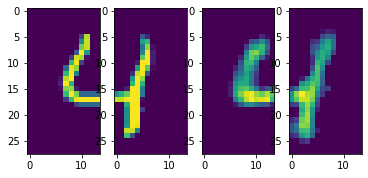

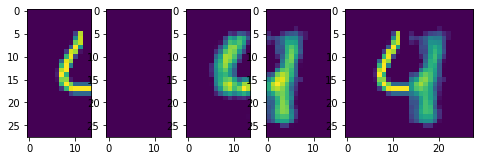

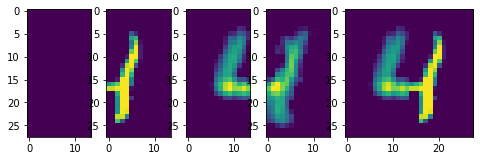

In [ ]:
plt.figure()
index = 4
plt.figure(figsize=(6,10))
plt.subplot(1,4,1)
plt.imshow(images_l[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,2)
plt.imshow(images_r[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,3)
plt.imshow(recx[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,4)
plt.imshow(recy[index].detach().cpu().reshape(28,14))


fig, axs = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig.set_size_inches(8, 12)
axs[0].imshow(images_l[index].detach().cpu().reshape(28,14))
axs[1].imshow(image_r_zero[index].detach().cpu().reshape(28,14))
axs[2].imshow(recx_l[index].detach().cpu().reshape(28,14))
axs[3].imshow(recy_l[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = images_l[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = recy_l[index].detach().cpu().reshape(28,14)
axs[4].imshow(comp_image)


fig1, axs1 = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig1.set_size_inches(8, 12)
axs1[0].imshow(image_l_zero[index].detach().cpu().reshape(28,14))
axs1[1].imshow(images_r[index].detach().cpu().reshape(28,14))
axs1[2].imshow(recx_r[index].detach().cpu().reshape(28,14))
axs1[3].imshow(recy_r[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = recx_r[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = images_r[index].detach().cpu().reshape(28,14)
axs1[4].imshow(comp_image)

<Figure size 432x288 with 0 Axes>

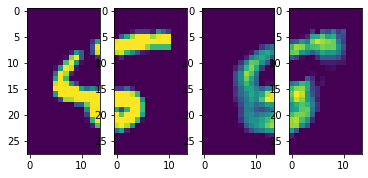

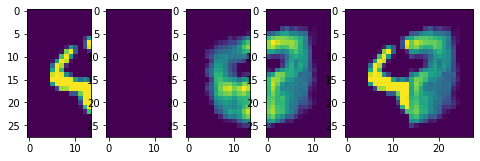

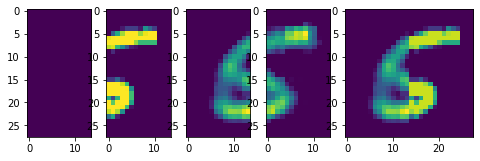

In [ ]:
plt.figure()
index = 8

plt.figure(figsize=(6,10))
plt.subplot(1,4,1)
plt.imshow(images_l[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,2)
plt.imshow(images_r[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,3)
plt.imshow(recx[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,4)
plt.imshow(recy[index].detach().cpu().reshape(28,14))


fig, axs = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig.set_size_inches(8, 12)
axs[0].imshow(images_l[index].detach().cpu().reshape(28,14))
axs[1].imshow(image_r_zero[index].detach().cpu().reshape(28,14))
axs[2].imshow(recx_l[index].detach().cpu().reshape(28,14))
axs[3].imshow(recy_l[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = images_l[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = recy_l[index].detach().cpu().reshape(28,14)
axs[4].imshow(comp_image)


fig1, axs1 = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig1.set_size_inches(8, 12)
axs1[0].imshow(image_l_zero[index].detach().cpu().reshape(28,14))
axs1[1].imshow(images_r[index].detach().cpu().reshape(28,14))
axs1[2].imshow(recx_r[index].detach().cpu().reshape(28,14))
axs1[3].imshow(recy_r[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = recx_r[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = images_r[index].detach().cpu().reshape(28,14)
axs1[4].imshow(comp_image)

<Figure size 432x288 with 0 Axes>

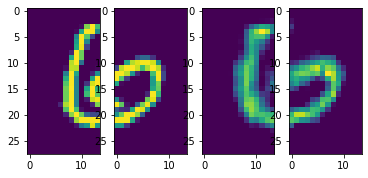

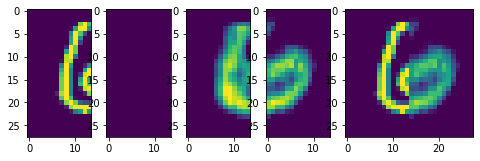

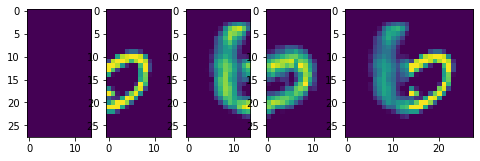

In [ ]:
plt.figure()
index = 11

plt.figure(figsize=(6,10))
plt.subplot(1,4,1)
plt.imshow(images_l[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,2)
plt.imshow(images_r[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,3)
plt.imshow(recx[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,4)
plt.imshow(recy[index].detach().cpu().reshape(28,14))


fig, axs = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig.set_size_inches(8, 12)
axs[0].imshow(images_l[index].detach().cpu().reshape(28,14))
axs[1].imshow(image_r_zero[index].detach().cpu().reshape(28,14))
axs[2].imshow(recx_l[index].detach().cpu().reshape(28,14))
axs[3].imshow(recy_l[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = images_l[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = recy_l[index].detach().cpu().reshape(28,14)
axs[4].imshow(comp_image)


fig1, axs1 = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig1.set_size_inches(8, 12)
axs1[0].imshow(image_l_zero[index].detach().cpu().reshape(28,14))
axs1[1].imshow(images_r[index].detach().cpu().reshape(28,14))
axs1[2].imshow(recx_r[index].detach().cpu().reshape(28,14))
axs1[3].imshow(recy_r[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = recx_r[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = images_r[index].detach().cpu().reshape(28,14)
axs1[4].imshow(comp_image)

<Figure size 432x288 with 0 Axes>

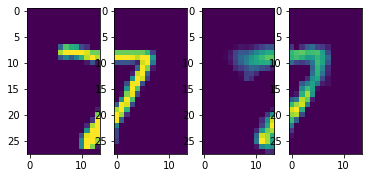

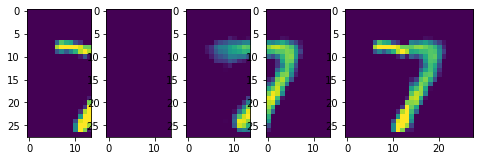

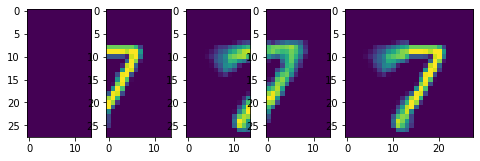

In [ ]:
plt.figure()
index = 0

plt.figure(figsize=(6,10))
plt.subplot(1,4,1)
plt.imshow(images_l[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,2)
plt.imshow(images_r[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,3)
plt.imshow(recx[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,4)
plt.imshow(recy[index].detach().cpu().reshape(28,14))


fig, axs = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig.set_size_inches(8, 12)
axs[0].imshow(images_l[index].detach().cpu().reshape(28,14))
axs[1].imshow(image_r_zero[index].detach().cpu().reshape(28,14))
axs[2].imshow(recx_l[index].detach().cpu().reshape(28,14))
axs[3].imshow(recy_l[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = images_l[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = recy_l[index].detach().cpu().reshape(28,14)
axs[4].imshow(comp_image)


fig1, axs1 = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig1.set_size_inches(8, 12)
axs1[0].imshow(image_l_zero[index].detach().cpu().reshape(28,14))
axs1[1].imshow(images_r[index].detach().cpu().reshape(28,14))
axs1[2].imshow(recx_r[index].detach().cpu().reshape(28,14))
axs1[3].imshow(recy_r[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = recx_r[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = images_r[index].detach().cpu().reshape(28,14)
axs1[4].imshow(comp_image)

In [ ]:
#batch = next(iter(test_loader))
i = iter(test_loader)
batch = next(i)
batch = next(i)
images, labels = batch[0].to(device),batch[1].to(device)

images_l = images[:,:,:,:14]
images_r = images[:,:,:,14:]

image_l_zero = torch.zeros(images_l.shape).to(device)
image_r_zero = torch.zeros(images_r.shape).to(device)

hidden_rep,recx,recy,hx1,hx2,hy1,hy2 = network(images_l,images_r)
hidden_rep_l,recx_l,recy_l,hx1_l,hx2_l,hy1_l,hy2_l = network(images_l,image_r_zero)
hidden_rep_r,recx_r,recy_r,hx1_r,hx2_r,hy1_r,hy2_r = network(image_l_zero,images_r)

<Figure size 432x288 with 0 Axes>

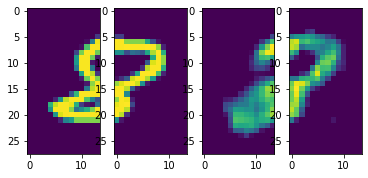

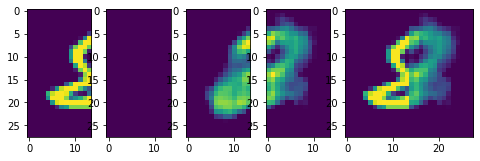

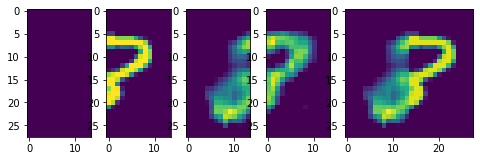

In [ ]:
plt.figure()
index = 11

plt.figure(figsize=(6,10))
plt.subplot(1,4,1)
plt.imshow(images_l[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,2)
plt.imshow(images_r[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,3)
plt.imshow(recx[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,4)
plt.imshow(recy[index].detach().cpu().reshape(28,14))


fig, axs = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig.set_size_inches(8, 12)
axs[0].imshow(images_l[index].detach().cpu().reshape(28,14))
axs[1].imshow(image_r_zero[index].detach().cpu().reshape(28,14))
axs[2].imshow(recx_l[index].detach().cpu().reshape(28,14))
axs[3].imshow(recy_l[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = images_l[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = recy_l[index].detach().cpu().reshape(28,14)
axs[4].imshow(comp_image)


fig1, axs1 = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig1.set_size_inches(8, 12)
axs1[0].imshow(image_l_zero[index].detach().cpu().reshape(28,14))
axs1[1].imshow(images_r[index].detach().cpu().reshape(28,14))
axs1[2].imshow(recx_r[index].detach().cpu().reshape(28,14))
axs1[3].imshow(recy_r[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = recx_r[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = images_r[index].detach().cpu().reshape(28,14)
axs1[4].imshow(comp_image)

<Figure size 432x288 with 0 Axes>

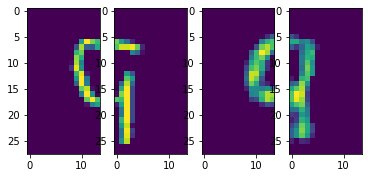

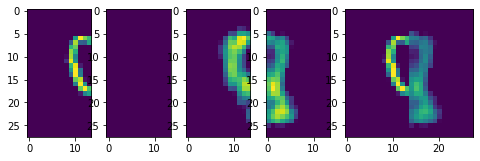

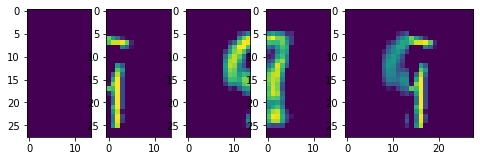

In [ ]:
plt.figure()
index = 12

plt.figure(figsize=(6,10))
plt.subplot(1,4,1)
plt.imshow(images_l[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,2)
plt.imshow(images_r[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,3)
plt.imshow(recx[index].detach().cpu().reshape(28,14))
plt.subplot(1,4,4)
plt.imshow(recy[index].detach().cpu().reshape(28,14))


fig, axs = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig.set_size_inches(8, 12)
axs[0].imshow(images_l[index].detach().cpu().reshape(28,14))
axs[1].imshow(image_r_zero[index].detach().cpu().reshape(28,14))
axs[2].imshow(recx_l[index].detach().cpu().reshape(28,14))
axs[3].imshow(recy_l[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = images_l[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = recy_l[index].detach().cpu().reshape(28,14)
axs[4].imshow(comp_image)


fig1, axs1 = plt.subplots(1, 5, gridspec_kw={'width_ratios': [2, 2,2,2,4]})
fig1.set_size_inches(8, 12)
axs1[0].imshow(image_l_zero[index].detach().cpu().reshape(28,14))
axs1[1].imshow(images_r[index].detach().cpu().reshape(28,14))
axs1[2].imshow(recx_r[index].detach().cpu().reshape(28,14))
axs1[3].imshow(recy_r[index].detach().cpu().reshape(28,14))
comp_image = np.zeros((28,28))
comp_image[:,0:14] = recx_r[index].detach().cpu().reshape(28,14)
comp_image[:,14:] = images_r[index].detach().cpu().reshape(28,14)
axs1[4].imshow(comp_image)

# Try calculating accuracy

In [ ]:
class MNIST_classifier(nn.Module):
    def __init__(self):
        super(MNIST_classifier,self).__init__()
        self.fc1 = nn.Linear(in_features=50,out_features=25) # 28*28 --> 512
        self.fc3 = nn.Linear(in_features=25,out_features=10) # 512 --> 10
        self.dropout = nn.Dropout(0.2)
    
    def forward(self,x):
        #x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
classifier = MNIST_classifier() #
classifier.to(device)
optimizer_class = optim.Adam(classifier.parameters(),lr=0.0001)


In [ ]:
# training the classifier with hidden layer as the input
for epoch in range(10):
    total_loss = 0.0
    for batch in test_loader:
        #images, labels = batch[0].to(device),batch[1].to(device)
        images, labels = batch[0].to(device),batch[1].to(device)
        images_l = images[:,:,:,:14]
        images_r = images[:,:,:,14:]

        hidden_rep,recx,recy,hx1,hx2,hy1,hy2 = network(images_l,images_r)
        
        preds = classifier(hidden_rep)
        loss = F.cross_entropy(preds,labels)
        
        optimizer_class.zero_grad()
        loss.backward()
        optimizer_class.step()
        total_loss += loss.item()
    #network_uniform_loss.append(total_loss)

    total = 0
    correct = 0
    for data in test_loader:
        images, labels = data[0].to(device),data[1].to(device)
       
        images_l = images[:,:,:,:14]
        images_r = images[:,:,:,14:]

        hidden_rep,recx,recy,hx1,hx2,hy1,hy2 = network(images_l,images_r)

        outputs = classifier(hidden_rep)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    #network_uniform_accuracy.append(correct/total)
    print("epoch: ",epoch,"loss: ",total_loss,"accuracy: ",correct/total)

epoch:  0 loss:  2382.854186296463 accuracy:  0.593
epoch:  1 loss:  1616.8273090720177 accuracy:  0.7143
epoch:  2 loss:  1169.5008001327515 accuracy:  0.7634
epoch:  3 loss:  943.6257965862751 accuracy:  0.7938
epoch:  4 loss:  814.8915527164936 accuracy:  0.8073
epoch:  5 loss:  733.896488904953 accuracy:  0.8227
epoch:  6 loss:  676.8491260260344 accuracy:  0.8365
epoch:  7 loss:  636.7565386146307 accuracy:  0.8454
epoch:  8 loss:  602.3610807210207 accuracy:  0.8589
epoch:  9 loss:  579.5082789957523 accuracy:  0.8584


- Input is just left view.
- First complete image is reconstructed from above trained model
- Accuracy is calculated using the MNIST classifier

In [ ]:
correct_l = 0
total_l  = 0

correct_r = 0
total_r  = 0
for batch in test_loader:
    images, labels = batch[0].to(device),batch[1].to(device)
    images_l = images[:,:,:,:14]
    images_r = images[:,:,:,14:]
    
    image_l_zero = torch.zeros(images_l.shape).to(device)
    image_r_zero = torch.zeros(images_r.shape).to(device)

    #hidden_rep,recx,recy,hx1,hx2,hy1,hy2 = network(images_l,images_r)
    hidden_rep_l,recx_l,recy_l,hx1_l,hx2_l,hy1_l,hy2_l = network(images_l,image_r_zero)
    hidden_rep_r,recx_r,recy_r,hx1_r,hx2_r,hy1_r,hy2_r = network(image_l_zero,images_r)

    rec_l = torch.zeros(images.shape).to(device)
    rec_l[:,:,:,0:14] = recx_l
    rec_l[:,:,:,14:] = recy_l

    rec_r = torch.zeros(images.shape).to(device)
    rec_r[:,:,:,0:14] = recx_r
    rec_r[:,:,:,14:] = recy_r

    outputs_l = classifier(hidden_rep_l)
    _, predicted_l = torch.max(outputs_l.data, 1)
    total_l += labels.size(0)
    correct_l += (predicted_l == labels).sum().item()

    outputs_r = classifier(hidden_rep_r)
    _, predicted_r = torch.max(outputs_r.data, 1)
    total_r += labels.size(0)
    correct_r += (predicted_r == labels).sum().item()

In [ ]:
print("Accuracy using only left part of image ",correct_l/total_l)
print("Accuracy using only right part of image ",correct_r/total_r)

Accuracy using only left part of image  0.7425
Accuracy using only right part of image  0.7768
